In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# try:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)
# except:
#   # Invalid device or cannot modify virtual devices once initialized.
#   pass

load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

# Choose subontology (CCO, MFO or BPO)
SO = 'BPO'

2023-06-10 18:06:37.072635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 18:06:37.525126: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1
/mnt/e/ML/cafa-5-protein-function-prediction


2023-06-10 18:06:38.256481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 18:06:38.274977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 18:06:38.275316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

In [3]:
import networkx
import obonet

# Read the taxrank ontology
url = os.path.join(DATA_PATH, "Train/go-basic.obo")
graph = obonet.read_obo(url)



In [4]:
df = pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

dfSO = df.loc[df["aspect"]==SO]
uniqueTerms = dfSO["term"].unique()
termsArr = list(dfSO["term"].to_numpy())

uniqueTermsDict={}
for i,el in enumerate(uniqueTerms):
    uniqueTermsDict[el] = i
    
print(dfSO.shape)
df=dfSO

df.set_index("EntryID", inplace=True)

(3497732, 3)


In [5]:
testID = df.index.to_list()[0]

## GO analysis

In [6]:
item_counts = df["term"].value_counts()

In [7]:
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

## Label encoding

The task is a multilabel classification: The output has several possible targets (Gene Ontologies) but each can only be 1 (existing) or 0 (non existing)

Extract label weights from IA

In [8]:
dfIa = pd.read_csv(os.path.join(DATA_PATH, "IA.txt"), sep='\t', header=None)

dfIa.set_index(0, inplace=True)

labelWeights=[]
allIndices = dfIa.index.tolist()

notFound=0
for go in item_counts.index.to_list():
    if go in allIndices:
        labelWeights.append(dfIa.loc[go].to_numpy()[0])
    else:
        notFound += 1
        labelWeights.append(0)

print("Not found GOs: {} (set to 0)".format(notFound))

Not found GOs: 0 (set to 0)


In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
import pickle

topGOs= item_counts
topGOs=topGOs.index.to_list()

mlb = MultiLabelBinarizer()
mlb.fit([topGOs])

dftest=df.loc[testID]
indices = dftest["term"].to_numpy()
print(indices)
print(mlb.transform([indices]))
print(len(mlb.classes_))

with open(os.path.join(DATA_PATH,'MLB_'+SO+'.pkl'), 'wb') as f:
    pickle.dump(mlb, f)

['GO:0008152' 'GO:0034655' 'GO:0072523' 'GO:0044270' 'GO:0006753'
 'GO:1901292' 'GO:0044237' 'GO:1901360' 'GO:0008150' 'GO:1901564'
 'GO:1901565' 'GO:0009117' 'GO:0006139' 'GO:0044281' 'GO:0046496'
 'GO:0019362' 'GO:0046483' 'GO:0055086' 'GO:0044248' 'GO:0019439'
 'GO:0019637' 'GO:0006807' 'GO:0019677' 'GO:1901361' 'GO:0006163'
 'GO:0046700' 'GO:0009987' 'GO:0006725' 'GO:0006796' 'GO:0034641'
 'GO:0072521' 'GO:0071704' 'GO:0019364' 'GO:1901575' 'GO:0072526'
 'GO:0046434' 'GO:0009166' 'GO:0072524' 'GO:0006195' 'GO:0009056'
 'GO:0044238' 'GO:0006793' 'GO:0019674']
[[0 0 0 ... 0 0 0]]
21285


## Amino acids encoding

In [10]:
aminos_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'X']

In [11]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## Build Dataset

In [12]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


In [13]:

dfAll=pd.read_csv(os.path.join(DATA_PATH, "Train/train_terms.tsv"), sep='\t')

soEntries = dfAll.loc[dfAll["aspect"]==SO]
soEntryIds = soEntries["EntryID"].unique()

# print(len(seqEntries))
print(soEntryIds)

# SoSequences = []
# for entry in soEntryIds:
#     SoSequences.append(sequences[ids.index(entry)])

# print(len(SoSequences))
dfAll.set_index("EntryID", inplace=True)

['A0A009IHW8' 'A0A021WW32' 'A0A023FFD0' ... 'X5L1L5' 'X5L565' 'X5M5N0']


In [14]:
import warnings
from itertools import product
from tqdm import tqdm
import os

TRAIN_VAL_SPLIT = 0.7
k = 3

allAA = list(aa_dict.keys())
allAA.sort()
allCombinations= list(product(*(allAA for i in range(k))))
allCombinations=np.array([''.join(el) for el in allCombinations])

positionDict = dict(zip(allCombinations, np.arange(0,allCombinations.size).T))

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
random.seed(516213)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)


#Train Validation Split
split = int(np.floor(len(sequencesShuffle)*TRAIN_VAL_SPLIT))
print(split)
trainSeq = sequencesShuffle[0:split]
valSeq = sequencesShuffle[split+1:]
trainIds = idsShuffle[0:split]
valIds = idsShuffle[split+1:]


def generator():
  for i,seq in enumerate(trainSeq):
      entryId = trainIds[i]
      
      if entryId in soEntryIds:
        labelData = df.loc[entryId]
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()
      else:
        indices=[]

      with warnings.catch_warnings():
          #supress the warnings for unknown classes
          warnings.simplefilter("ignore")
          y = mlb.transform([indices])
      
      
      kmers = [seq[i:i+k] if i < len(seq)-(k-1) else 0 for i,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for j,v in enumerate(values):
          freqVector[positionDict[v]] = counts[j]
      yield (freqVector,y[0])


def generatorVal():
  for i,seq in enumerate(valSeq):
      entryId = valIds[i]
      if entryId in soEntryIds:
        labelData = df.loc[entryId]
        # indices = labelData["termToken"].to_numpy()
        indices = labelData["term"].to_numpy()
      else:
        indices=[]

      with warnings.catch_warnings():
          #supress the warnings for unknown classes
          warnings.simplefilter("ignore")
          y = mlb.transform([indices])
      
      kmers = [seq[i:i+k] if i < len(seq)-(k-1) else 0 for i,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for j,v in enumerate(values):
          freqVector[positionDict[v]] = counts[j]
      yield (freqVector,y[0])
        

99572


In [15]:
g = generator()
test = next(g)
print("The first sample: \n{}\n{}".format(test[0].shape, test[0][0:100]))
print("The first sample has {} classes".format(np.count_nonzero(test[1])))

The first sample: 
(15625,)
[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0.]
The first sample has 0 classes


## Tensorflow Classification

In [16]:

xSize = allCombinations.shape[0]

dataset = tf.data.Dataset.from_generator(generator, output_signature=(
         tf.TensorSpec(shape=(xSize,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))
print(list(dataset.take(1)))

datasetVal = tf.data.Dataset.from_generator(generatorVal, output_signature=(
         tf.TensorSpec(shape=(None,), dtype=tf.int32),
         tf.TensorSpec(shape=(len(mlb.classes_),), dtype=tf.int32)))

2023-06-10 18:06:52.382003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 18:06:52.382477: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 18:06:52.382909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 18:06:52.956703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-10 18:06:52.957064: I tensorflow/compile

[(<tf.Tensor: shape=(15625,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>, <tf.Tensor: shape=(21285,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)]


2023-06-10 18:06:53.203731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [17]:
%load_ext tensorboard


In [18]:
from tensorflow.keras import layers

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=100

def createModel():
    inputs = tf.keras.Input(shape=(xSize,))
    # x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, name="embedding")(inputs)

    x=layers.Conv1D(8, 7,strides=2, activation=tf.keras.activations.relu)(tf.expand_dims(inputs,2))
    x=layers.Conv1D(8, 7,strides=2, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(8, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)
    x=layers.Conv1D(16, 7, activation=tf.keras.activations.relu)(x)

    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    # x=layers.Conv1D(32, 5, activation=tf.keras.activations.relu)(x)
    x=layers.Flatten()(x)
    x=layers.Dense(256)(x)
    x=layers.LeakyReLU()(x)
    x=layers.Dense(256)(x)
    x=layers.LeakyReLU()(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedConvModel")

model = createModel()

model.summary()


Model: "embedConvModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15625)]           0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 15625, 1)         0         
                                                                 
 conv1d (Conv1D)             (None, 7810, 8)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 3902, 8)           456       
                                                                 
 conv1d_2 (Conv1D)           (None, 3896, 8)           456       
                                                                 
 conv1d_3 (Conv1D)           (None, 3890, 16)          912       
                                                                 
 conv1d_4 (Conv1D)           (None, 3884, 16)       

In [19]:

VOCAB_SIZE=len(aa_dict)
EMBED_DIM=500
OUT_SEQ_LENGTH=10

def createRnnModel():
    inputs = tf.keras.Input(shape=(TRUNCATE,))
    # x = tf.keras.layers.Masking(0)(inputs)
    x=layers.Embedding(VOCAB_SIZE, EMBED_DIM, mask_zero=True, name="embedding")(inputs)

    # x = layers.RepeatVector(OUT_SEQ_LENGTH)(x)

    x = layers.Bidirectional(layers.LSTM(200, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(200))(x)
    # x = layers.LSTM(64)(x)
    x = layers.Dense(500)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dense(500)(x)
    outputs=layers.Dense(len(mlb.classes_), activation=tf.keras.activations.sigmoid)(x)
    # outputs=layers.Softmax()(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name="embedRnnModel")

# model = createRnnModel()

# model.summary()

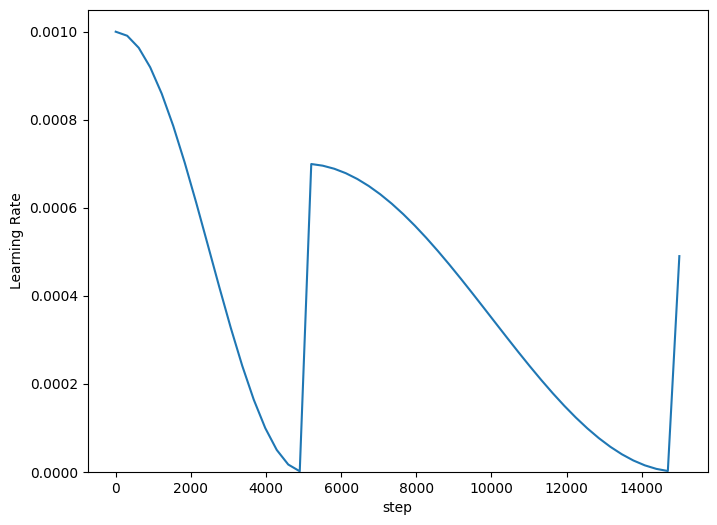

In [20]:
import matplotlib.pyplot as plt
#Learning rate schedule
initial_learning_rate = 0.001
decaySteps=5000
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(initial_learning_rate, first_decay_steps=decaySteps,
                                                                t_mul=2.0, m_mul=0.7)
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
#     initial_learning_rate, decay_steps=decaySteps, alpha=0.01)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,decay_steps=decaySteps,decay_rate=0.9,staircase=False)
step = np.linspace(0,decaySteps*3)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
# plt.yscale("log")
plt.plot(step, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('step')
_ = plt.ylabel('Learning Rate')

In [21]:
from tensorflow.keras.losses import Loss

class WeightedBinaryCE(Loss):
    # initialize instance attributes
    def __init__(self, classWeights, labelSmoothing=0.0):
        super(WeightedBinaryCE, self).__init__()
        self.labelSmoothing = tf.constant(labelSmoothing, dtype=tf.dtypes.float32)
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        
    # Compute loss
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        if(self.labelSmoothing>0):
            y_true = y_true*(1-self.labelSmoothing)+self.labelSmoothing/2
        y_pred = tf.cast(y_pred, tf.float32)
        y_pred = tf.clip_by_value(y_pred,tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        term_0 = tf.math.multiply(self.classWeights * tf.math.subtract(1.0 , y_true), tf.math.log(tf.math.subtract(1.0, y_pred) + tf.keras.backend.epsilon()))
        term_1 = tf.math.multiply(self.classWeights * y_true, tf.math.log(y_pred + tf.keras.backend.epsilon()))
        losses = term_0 + term_1
        return -tf.reduce_mean(losses, axis=0)
    

testLoss = WeightedBinaryCE([1,1,1])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.42,0.111,0.957], [0.877,0.121,0.544]])

print(testLoss(labelsTrue, labelsPred))
kerasCE = tf.keras.losses.BinaryCrossentropy()
print(kerasCE(labelsTrue, labelsPred))


tf.Tensor(0.6762641, shape=(), dtype=float32)
tf.Tensor(0.6762641, shape=(), dtype=float32)


In [22]:


class DiceLoss(Loss):
    # initialize instance attributes
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    # Compute loss
    def call(self, y_true, y_pred, smooth=1e-6):
      inputs = tf.squeeze(tf.cast(y_pred, tf.dtypes.float32))
      targets = tf.squeeze(tf.cast(y_true, tf.dtypes.float32))
    
      intersection = tf.math.reduce_sum(tf.math.multiply(targets, inputs))
      dice = (2*intersection + smooth) / (tf.math.reduce_sum(targets) + tf.math.reduce_sum(inputs) + smooth)
      return 1 - dice
    

testLoss = DiceLoss()
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.999,0.0001,0.99], [0.9,0.921,0.01]])

print(testLoss(labelsTrue, labelsPred))


tf.Tensor(0.025587916, shape=(), dtype=float32)


In [23]:


# α controls the amount of Dice term contribution in the loss f
# β ∈ [0, 1] controls the level of model penalization for false positives/negatives: when β is set to
# a value smaller than 0.5, FP are penalized more than FN


class WeightedComboLoss(Loss):
    # initialize instance attributes
    def __init__(self, labelWeights, alpha=0.5, beta=0.5):
        super(WeightedComboLoss, self).__init__()
        self.classWeights = tf.constant(labelWeights, dtype=tf.dtypes.float32)
        self.alpha=tf.constant(alpha, dtype=tf.dtypes.float32)
        self.beta=tf.constant(beta, dtype=tf.dtypes.float32)
        
    # Compute loss
    def call(self, y_true, y_pred, smooth=1e-6):
      inputs = tf.squeeze(tf.cast(y_pred, tf.dtypes.float32))
      targets = tf.squeeze(tf.cast(y_true, tf.dtypes.float32))
    
      intersection = tf.math.reduce_sum(tf.math.multiply(targets, inputs))
      dice = (2*intersection + smooth) / (tf.math.reduce_sum(targets) + tf.math.reduce_sum(inputs) + smooth)
     
      y_true = tf.cast(y_true, tf.float32)
      y_pred = tf.cast(y_pred, tf.float32)
      y_pred = tf.clip_by_value(y_pred,tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
      term_0 = tf.math.multiply((1-self.beta) * self.classWeights * tf.math.subtract(1.0 , y_true), tf.math.log(tf.math.subtract(1.0, y_pred) + tf.keras.backend.epsilon()))
      term_1 = tf.math.multiply(self.beta * self.classWeights * y_true, tf.math.log(y_pred + tf.keras.backend.epsilon()))
      losses = term_0 + term_1
      weightedCE = -tf.reduce_mean(losses, axis=0)

      combo = (self.alpha * weightedCE) - ((1 - self.alpha) * dice)

      return combo
    

testLoss = WeightedComboLoss([1,1,1])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.9,0.1,0.9], [0.8,0.9,0.05]])

print(testLoss(labelsTrue, labelsPred))


tf.Tensor(-0.4285214, shape=(), dtype=float32)


In [24]:

class WeightedF1(tf.keras.metrics.Metric):
    def __init__(self, classWeights, threshold=0.5):
        super(WeightedF1, self).__init__()
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        self.threshold= tf.constant(threshold, dtype=tf.dtypes.float32)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.total = self.add_weight('total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        m = tf.math.count_nonzero(tf.reduce_max(y_pred, axis=1))
        n = tf.shape(y_pred)[0]
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.math.greater_equal(y_pred,self.threshold)
   

        tp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        tp = tf.cast(tp, self.dtype)
        tp = tf.math.multiply(tp, self.classWeights)
        tp = tf.cast(tp, self.dtype)

        tn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False))
        tn = tf.cast(tn, self.dtype)
        tn = tf.math.multiply(tn, self.classWeights)
        tn = tf.cast(tn, self.dtype)

        fp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        fp = tf.cast(fp, self.dtype)
        fp = tf.math.multiply(fp, self.classWeights)
        fp = tf.cast(fp, self.dtype)

        fn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        fn = tf.cast(fn, self.dtype)
        fn = tf.math.multiply(fn, self.classWeights)
        fn = tf.cast(fn, self.dtype)

        pr = tf.math.divide(tf.math.reduce_sum(tp, axis=1),tf.math.reduce_sum(tp+fp+tf.keras.backend.epsilon(), axis=1))
        m = tf.cast(m, pr.dtype)
        if(m>0):
            wPr = tf.math.reduce_sum(pr)/m
        else:
            wPr = tf.constant(0, tf.dtypes.float32)

        re = tf.math.divide(tf.math.reduce_sum(tp, axis=1),tf.math.reduce_sum(tp+fn+tf.keras.backend.epsilon(), axis=1))
        n = tf.cast(n, re.dtype)
        wRe = tf.math.reduce_sum(re)/n

        res = tf.math.divide(2*wPr*wRe, wPr + wRe + tf.keras.backend.epsilon())

        self.f1.assign_add(res)
        self.total.assign_add(1)

    def result(self):
        return tf.math.divide(self.f1, self.total)

testM = WeightedF1(classWeights=[1,1,2])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.8,0.1,0.9], [0,0,0]])

testM.update_state(labelsTrue, labelsPred)
testM.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.66666657>

In [25]:
class WeightedPrecision(tf.keras.metrics.Metric):
    def __init__(self, classWeights, threshold=0.5):
        super(WeightedPrecision, self).__init__()
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        self.threshold= tf.constant(threshold, dtype=tf.dtypes.float32)
        self.prec = self.add_weight(name='prec', initializer='zeros')
        self.total = self.add_weight('total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        m = tf.math.count_nonzero(tf.reduce_max(y_pred, axis=1))
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.math.greater_equal(y_pred,self.threshold)
   

        tp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        tp = tf.cast(tp, self.dtype)
        tp = tf.math.multiply(tp, self.classWeights)
        tp = tf.cast(tp, self.dtype)

        fp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        fp = tf.cast(fp, self.dtype)
        fp = tf.math.multiply(fp, self.classWeights)
        fp = tf.cast(fp, self.dtype)

        pr = tf.math.divide(tf.math.reduce_sum(tp, axis=1),tf.math.reduce_sum(tp+fp+tf.keras.backend.epsilon(), axis=1))
        m = tf.cast(m, pr.dtype)
        if(m>0):
            wPr = tf.math.reduce_sum(pr)/m
        else:
            wPr = tf.constant(0, tf.dtypes.float32)


        self.prec.assign_add(wPr)
        self.total.assign_add(1)

    def result(self):
        return tf.math.divide(self.prec, self.total)

testM = WeightedPrecision(classWeights=[1,1,1])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.8,0.1,0.9], [0,0,0]])

testM.update_state(labelsTrue, labelsPred)
testM.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.99999976>

In [26]:
class WeightedRecall(tf.keras.metrics.Metric):
    def __init__(self, classWeights, threshold=0.5):
        super(WeightedRecall, self).__init__()
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        self.threshold= tf.constant(threshold, dtype=tf.dtypes.float32)
        self.rec = self.add_weight(name='rec', initializer='zeros')
        self.total = self.add_weight('total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        n = tf.shape(y_pred)[0]
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.math.greater_equal(y_pred,self.threshold)
   

        tp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        tp = tf.cast(tp, self.dtype)
        tp = tf.math.multiply(tp, self.classWeights)
        tp = tf.cast(tp, self.dtype)

        fn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        fn = tf.cast(fn, self.dtype)
        fn = tf.math.multiply(fn, self.classWeights)
        fn = tf.cast(fn, self.dtype)

        re = tf.math.divide(tf.math.reduce_sum(tp, axis=1),tf.math.reduce_sum(tp+fn+tf.keras.backend.epsilon(), axis=1))
        n = tf.cast(n, re.dtype)
        wRe = tf.math.reduce_sum(re)/n

        self.rec.assign_add(wRe)
        self.total.assign_add(1)

    def result(self):
        return tf.math.divide(self.rec, self.total)

testM = WeightedRecall(classWeights=[1,1,1])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.8,0.1,0.9], [0,0,0.2]])

testM.update_state(labelsTrue, labelsPred)
testM.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.49999988>

In [27]:


class WeightedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, classWeights, threshold=0.5):
        super(WeightedAccuracy, self).__init__()
        self.classWeights= tf.constant(classWeights, dtype=tf.dtypes.float32)
        self.threshold= tf.constant(threshold, dtype=tf.dtypes.float32)
        self.acc = self.add_weight(name='acc', initializer='zeros')
        self.total = self.add_weight('total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        n = tf.shape(y_pred)[0]
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.math.greater_equal(y_pred,self.threshold)
   

        tp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True))
        tp = tf.cast(tp, self.dtype)
        tp = tf.math.multiply(tp, self.classWeights)
        tp = tf.cast(tp, self.dtype)

        tn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False))
        tn = tf.cast(tn, self.dtype)
        tn = tf.math.multiply(tn, self.classWeights)
        tn = tf.cast(tn, self.dtype)

        fp = tf.math.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False))
        fp = tf.cast(fp, self.dtype)
        fp = tf.math.multiply(fp, self.classWeights)
        fp = tf.cast(fp, self.dtype)

        fn = tf.math.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True))
        fn = tf.cast(fn, self.dtype)
        fn = tf.math.multiply(fn, self.classWeights)
        fn = tf.cast(fn, self.dtype)

        acc = tf.math.divide(tf.math.reduce_sum(tp+tn, axis=1),tf.math.reduce_sum(tp+fn+tn+fp+tf.keras.backend.epsilon(), axis=1))
        n = tf.cast(n, acc.dtype)
        wAcc = tf.math.reduce_sum(acc)/n

        self.acc.assign_add(wAcc)
        self.total.assign_add(1)

    def result(self):
        return tf.math.divide(self.acc, self.total)

testM = WeightedAccuracy(classWeights=[1,1,1])
labelsTrue = tf.constant([[1,0,1], [1,1,0]])
labelsPred = tf.constant([[0.8,0.1,0.9], [0,0,0]])

testM.update_state(labelsTrue, labelsPred)
testM.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.66666657>

In [28]:
# BATCH_SIZE=32

# batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
# batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

# optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)

# loss_fn = WeightedBinaryCE(labelWeights)

# train_acc_metric = tf.keras.metrics.BinaryAccuracy()
# train_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
# train_prec = tf.keras.metrics.Precision()
# train_rec = tf.keras.metrics.Recall()

# model.compile(optimizer, loss_fn, metrics=[train_acc_metric,train_prec,train_f1_metric,train_rec ])

# model.fit(batchedDataset, epochs=1, validation_data=batchedDatasetVal)

In [ ]:
# import tensorflow_addons as tfa

BATCH_SIZE=64
LOG_INTERVAL=20
epochs = 30
saveModel=True


log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+"_"+SO
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                      write_graph=True, update_freq=5)


summary_writer = tf.summary.create_file_writer(log_dir)

# Instantiate an optimizer .
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# Instantiate a loss function.
# loss_fn = tf.keras.losses.BinaryCrossentropy()
# loss_fn = WeightedBinaryCE(np.ones(len(mlb.classes_)))
# loss_fn = WeightedBinaryCE(labelWeights)
loss_fn = WeightedComboLoss(labelWeights)

train_acc_metric = WeightedAccuracy(classWeights=labelWeights)
train_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
train_prec = WeightedPrecision(classWeights=labelWeights)
train_rec = WeightedRecall(classWeights=labelWeights)

val_acc_metric = WeightedAccuracy(classWeights=labelWeights)
val_f1_metric = WeightedF1(classWeights=labelWeights, threshold=0.5)
val_prec = WeightedPrecision(classWeights=labelWeights)
val_rec = WeightedRecall(classWeights=labelWeights)

batchedDataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
batchedDatasetVal = datasetVal.batch(BATCH_SIZE, drop_remainder=False)

# batchedDataset = batchedDataset.cache(os.path.join(DATA_PATH, "datasetCache"+SO))
# batchedDatasetVal = batchedDatasetVal.cache(os.path.join(DATA_PATH, "datasetCacheVal"+SO))

@tf.function()
def trainStep(x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:

        probs = model(x_batch_train, training=True) 
        loss_value = loss_fn(y_batch_train, probs)

    grads = tape.gradient(loss_value, model.trainable_weights)
    #Gradient clipping
    # grads = [tf.clip_by_norm(g, 2.0) for g in grads]

    optimizer.apply_gradients(zip(grads, model.trainable_weights)) 
    return loss_value, probs

@tf.function()
def valStep(x_batch_val, y_batch_val):
    valProbs = model(x_batch_val, training=False)
    # Update val metrics
    val_acc_metric.update_state(y_batch_val, valProbs)
    val_f1_metric.update_state(y_batch_val, valProbs)
    val_prec.update_state(y_batch_val, valProbs)
    val_rec.update_state(y_batch_val, valProbs)

maxStep=0

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch+1,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(batchedDataset):

        loss_value, probs=trainStep(x_batch_train,y_batch_train)

        train_acc_metric.update_state(y_batch_train, probs)
        train_f1_metric.update_state(y_batch_train, probs)
        train_prec.update_state(y_batch_train, probs)
        train_rec.update_state(y_batch_train, probs)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.5f}, Accuracy: {:.5f}, F1: {:.4f}, Prec: {:.4f}, Rec: {:.4f} lr: {:.5f}'
            print(template.format(epoch+1, step,loss_value.numpy(), 
                                    train_acc_metric.result(),train_f1_metric.result(),
                                    train_prec.result(), train_rec.result(), optimizer.learning_rate.numpy()))
            
            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_value, step=maxStep*epoch+step)
                tf.summary.scalar('accuracy', train_acc_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('f1', train_f1_metric.result(), step=maxStep*epoch+step)
                tf.summary.scalar('prec', train_prec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('rec', train_rec.result(), step=maxStep*epoch+step)
                tf.summary.scalar('learning rate', optimizer.learning_rate.numpy(), step=maxStep*epoch+step)
                summary_writer.flush()

    
    train_acc_metric.reset_states()
    train_f1_metric.reset_states()
    train_prec.reset_states()
    train_rec.reset_states()

    maxStep=step

    print("Epoch finished. Start validation")
    for x_batch_val, y_batch_val in batchedDatasetVal:
        valStep(x_batch_val, y_batch_val)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    val_f1 = val_f1_metric.result()
    val_f1_metric.reset_states()
    val_precision = val_prec.result()
    val_prec.reset_states()
    val_recall = val_rec.result()
    val_rec.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Validation f1: %.4f" % (float(val_f1),))
    print("Validation precision: %.4f" % (float(val_precision),))
    print("Validation recall: %.4f" % (float(val_recall),))
    with summary_writer.as_default():
        tf.summary.scalar('valAcc', float(val_acc), step=epoch)
        tf.summary.scalar('valF1', float(val_f1), step=epoch)
        tf.summary.scalar('valPrecision', float(val_precision), step=epoch)
        tf.summary.scalar('valRecall', float(val_recall), step=epoch)
        summary_writer.flush()
    if saveModel:
      model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valF1Score{:.3f}".format(epoch, float(val_f1))))

In [ ]:

# model.save(os.path.join(DATA_PATH, "model_"+SO+"_epoch_{}_valf1Score{:.3f}".format(epoch, float(val_f1))))

In [ ]:

probs= model.predict(tf.expand_dims(list(datasetVal.take(32))[10][0], 0))
prediction= [1 if p > 0.5 else 0 for p in probs[0]]
probabilities= probs[probs>0.5]
# classes = np.argwhere(prediction)
print(mlb.inverse_transform(np.array([prediction])))
print(probabilities)